# Econ570 Assigment2 Shuxian Mao 6221281532

In [179]:
import pandas as pd
import numpy as np
import random
import statsmodels.api as sm
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
import graphviz as gr
from matplotlib import style
import seaborn as sns
random.seed(570)

In [180]:
#Preparation
## Define a function to generate variance-covariance matrix
def fn_generate_cov(dim, *corr):
    # dim: number of covariates
    # corr: correlation for multivariate normal
    acc  = []
    for i in range(dim):
        row = np.ones((1,dim)) * corr
        row[0][i] = 1
        acc.append(row)
    return np.concatenate(acc,axis=0)

## Define a function to generate correlated random variables
def fn_generate_multnorm(nobs,corr,nvar):
# nobs: number of observations 
# nvar: number of covariates generated

    mu = np.zeros(nvar)
    std = (np.abs(np.random.normal(loc = 1, scale = .5,size = (nvar,1))))**(1/2)
    # generate random normal distribution
    acc = []
    for i in range(nvar):
        acc.append(np.reshape(np.random.normal(mu[i],std[i],nobs),(nobs,-1)))

    normvars = np.concatenate(acc,axis=1)

    cov = fn_generate_cov(nvar, corr)
    C = np.linalg.cholesky(cov)

    Y = np.transpose(np.dot(C,np.transpose(normvars)))
    return Y


# Define a function to randomly separate the samples to treated and non treated
def fn_randomize_treatment(N,p=0.5):
    # N: Number of observations
    # p: proportion of treated people in the sample

    treated = random.sample(range(N), round(N*p))
    return np.array([(1 if i in treated else 0) for i in range(N)]).reshape([N,1])


#Define a function to calculate the bias, rmse and size of treatment parameter
def fn_bias_rmse_size(theta0,thetahat,se_thetahat,cval = 1.96):
    # theta0: true parameter value
    # thetatahat: estimated parameter value
    # se_thetahat: estimated standard error of thetahat
    b = thetahat - theta0
    bias = np.mean(b)
    rmse = np.sqrt(np.mean(b**2))
    tval = b/se_thetahat # paramhat/se_paramhat H0: b = 0
    size = np.mean(1*(np.abs(tval)>cval))

    return (bias,rmse,size)

# Setting1: randomly assigned treatment and some observed covariates

$Y_i = \tau_i * T_i+\beta_i * X_i + e_i$

In [181]:
# Define a function to simulate data
def fn_generate_data(tau,N,p,beta0,corr = 0.5,conf = True,cov = True,covx = True,conxf = True):
    # tau: treatment effect parameter
    # N: Number of observations
    # p: Number of covariates
    # beta0: the matrix of true parameters of the observed covariates
    nvar = p+1 # Add 1 confounder

    if conf == False: # conf: confounding factors
        conf_mult = 0 # remove confounder from outcome
    else:
        conf_mult = 1

    if cov == False:   # cov: covariates factors
        cov_mult = 0 # remove observed covariates from outcome
    else:
        cov_mult = 1

    allX = fn_generate_multnorm(N,corr,nvar)
    C = allX[:,0].reshape([N,1]) # confounder
    X = allX[:,1:] # observed covariates
    T = fn_randomize_treatment(N) # choose treated units
    err = np.random.normal(0,1,[N,1])

    Yab = tau*T+cov_mult*X@beta0+conf_mult*0.6*C+err

    if covx == False:  # covx: Indicating whether we control the covariates
        X = np.zeros([N,1])

    if conxf == False:    # conxf: Indicating whether we control the confoundings
        C = np.zeros([N,1])

    return Yab, T, X, C

In [182]:
#Generate Data
tau = 2.5
N = 100
p = 1
beta0 = np.array([[5]]).reshape(1,-1)

Y, T, X, C = fn_generate_data(tau,N,p,beta0 ,corr = 0.5,conf = False,cov = True,covx = True,conxf = False)

In [21]:
data_1 = np.hstack([Y,T,X,C])
data_1 = pd.DataFrame(data_1)
data_1.columns = ["Y","Treatment","X","Confounder"]
data_1.to_csv("data_1.csv")

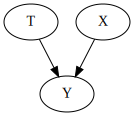

In [67]:
#DAG
g = gr.Digraph()
g.edge("T", "Y")
g.edge("X", "Y")
g

In [183]:
# Define a function to estimate the treatment effect of random sample using OLS
def fn_estimate_params(Y,T,X,C):
    # Y: Outcome value of Dependent Variable
    # T: Indicating the treatment group 0/1
    # X: observed covariates
    # C: Confounders

    covar = np.hstack([T,X,C])
    idx = np.argwhere(np.all(covar[..., :] == 0, axis=0))
    covars = np.delete(covar, idx, axis=1)      # remove columns with all zero value

    mod = sm.OLS(Y,covars)
    res = mod.fit()
    tauhat = res.params[0]
    se_tauhat = res.HC1_se[0]

    return tauhat,se_tauhat

In [184]:
# Define a function to do the monte carlo simulation
def run_mc_simulation(n_rep,tau,N,p,beta0,corr = 0.5,conf = False,cov = False,covx = True,conxf = True):

    estDict = {}
    for n in N:
        tauhats = []
        sehats = []
        for rep in tqdm(range(n_rep)):
            Y,T,X,C = fn_generate_data(tau,n,p,beta0,corr,conf,cov,covx,conxf)
            tauhat,sehat = fn_estimate_params(Y,T,X,C)
            tauhats = tauhats + [tauhat]
            sehats = sehats + [sehat]
        estDict[n] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
        }

    return estDict

In [185]:
# Define a function to summarize the results of monte carlo simulation
def summarize_mc_simulation(tau,n_rep,N,estDict):
    tau0 = tau*np.ones([n_rep,1])
    for N, results in estDict.items():
        (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                             results['sehat'])

        print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

In [186]:
#a: do not control any covariables
np.random.seed(570)
n_rep = 2000
tau = 2.5
N = [100,1000]
p = 1
beta0 = np.array([[5]]).reshape(1,-1)

estDict = run_mc_simulation(n_rep,tau,N,p,beta0,corr = 0.5,conf = False,cov = True,covx = False,conxf = False)
summarize_mc_simulation(tau,n_rep,N,estDict)

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:15<00:00, 130.39it/s]

N=100: bias=0.009578454864767239, RMSE=0.7275087659435233, size=0.0545
N=1000: bias=-0.0012293266285810943, RMSE=0.23631121363400598, size=0.053


In [148]:
#b: Control for all covariable
np.random.seed(570)
n_rep = 2000
tau = 2.5
N = [100,1000]
p = 1
beta0 = np.array([[5]]).reshape(1,-1)

estDict = run_mc_simulation(n_rep,tau,N,p,beta0,corr = 0.5,conf = False,cov = True,covx = True,conxf = False)
summarize_mc_simulation(tau,n_rep,N,estDict)

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:04<00:00, 412.36it/s]

N=100: bias=-0.0021216270970377494, RMSE=0.1274613139660042, size=0.0625
N=1000: bias=-0.0012437360580361502, RMSE=0.0396492922737336, size=0.047


Real-life eg

Consider a group of unemployed individuals, 
some of whom are given a policy intervention (treatment group) 
and the rest are given no treatment (control group).
In order to, study the effect of this policy (intervention) on the length of unemployment period,control their education level(observed covariable).

# Setting2: DGP with confounder

In [155]:
#Define a function to separate the samples to treated and non treated based on confounders
def fn_confounders_treatment(C,N):
    # C: Confounders
    # N: Number of observations (Sample size)

    err = np.random.normal(0,1,[N,1])
    treated = 1 + 2 * C + err
    treated_prob = 1/(1+np.exp(-treated))

    return np.array([(1 if treated_prob[i] >= 0.5 else 0) for i in range(N)]).reshape([N,1])

#Define a function to simulate data
def fn_generate_data(tau,N,p,beta0,corr = 0.5,conf = True,cov = True,covx = True,conxf = True):

    nvar = p+1 # Add 1 confounder

    if conf == False:
        conf_mult = 0 # Remove confounder from outcome
    else:
        conf_mult = 1

    if cov == False:
        cov_mult = 0 # remove observed covariates from outcome
    else:
        cov_mult = 1

    allX = fn_generate_multnorm(N,corr,nvar)
    C = allX[:,0].reshape([N,1]) # confounder
    X = allX[:,1:] # observed covariates

    T = fn_confounders_treatment(C,N) # choose treated units with the effect of C
    err = np.random.normal(0,1,[N,1])

    Yab = tau*T+cov_mult*X@beta0+conf_mult*0.6*C+err

    if covx == False:
        X = np.zeros([N,1])

    if conxf == False:
        C = np.zeros([N,1])

    return Yab, T, X, C

In [187]:
# Generate Data
np.random.seed(570)
tau = 2
N = 100
p = 1
beta0 = np.array([[5]])  .reshape(1,-1)

Y, T, X, C = fn_generate_data(tau,N,p,beta0,corr = 0.5,conf = True,cov = False,covx = False,conxf = True)

In [82]:
data_2 = np.hstack([Y,T,X,C])
data_2 = pd.DataFrame(data_2)
data_2.columns = ["Y","Treatment","X","Confounder"] 
data_2.to_csv("data_2.csv")

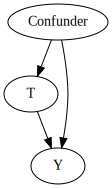

In [74]:
# DAG
g = gr.Digraph()
g.edge("Confunder", "T")
g.edge("T", "Y")
g.edge("Confunder", "Y")
g

In [188]:
## MC simulate
# a: fail to control
np.random.seed(20)
n_rep = 2000
tau = 2.5
N = [100,1000]
p = 1
beta0 = np.array([[5]]).reshape(1,-1)

estDict = run_mc_simulation(n_rep,tau,N,p,beta0,corr = 0.5,conf = True,cov = False,covx = False,conxf = False)
summarize_mc_simulation(tau,n_rep,N,estDict)

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:15<00:00, 130.43it/s]

N=100: bias=0.005311506033693411, RMSE=0.1661674293376382, size=0.057
N=1000: bias=0.0009153416436707818, RMSE=0.05191932522362733, size=0.0465


In [150]:
#b:do control the confounder
np.random.seed(570)
n_rep = 2000
tau = 2.5
N = [100,1000]
p = 1
beta0 = np.array([[5]]).reshape(1,-1)

estDict = run_mc_simulation(n_rep,tau,N,p,beta0,corr = 0.5,conf = True,cov = False,covx = False,conxf = True)
summarize_mc_simulation(tau,n_rep,N,estDict)

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:04<00:00, 412.95it/s]

N=100: bias=-0.003007456623045294, RMSE=0.13491080499252348, size=0.0635
N=1000: bias=-0.0009261386839264918, RMSE=0.04197211965869316, size=0.046


Real-life example

Infection with neo-coronavirus increases mortality. Younger individuals have better immune systems and are therefore less likely to be infected with NIV and have a lower mortality rate; older individuals have poorer resistance and are at higher risk of infection, while older individuals have a higher mortality rate. Thus, "age" is a confounding factor in the relationship between "neo-coronavirus infection" and "mortality".

# Setting3: Selection bias

In [214]:
# Define a function to simulate data
def fn_generate_selection_data(tau,N,sigma,beta,conts = False):
    # tau: treatment effect parameter
    # N: Number of observations
    # conts: selection bias variable

    T = fn_randomize_treatment(N) # choose treated units
    err = np.random.normal(0,1,[N,1])
    X = sigma*T + err
    err = np.random.normal(0,1,[N,1])

    Yab = tau*T+beta*X+err

    if conts == False:
        X = np.zeros([N,1])

    return Yab, T, X

# Define a function to estimate the treatment effect of random sample using OLS
def fn_estimate_params(Y,T,X):
    # Y: Outcome value of Dependent Variable
    # T: Indicating the treatment group 0/1
    # X: selection bias variable

    covar = np.hstack([T,X])
    idx = np.argwhere(np.all(covar[..., :] == 0, axis=0))
    covars = np.delete(covar, idx, axis=1)

    mod = sm.OLS(Y,covars)
    res = mod.fit()
    tauhat = res.params[0]
    se_tauhat = res.HC1_se[0]

    return tauhat,se_tauhat

# Define a function to do the monte carlo simulation
def run_mc_simulation(n_rep,tau,N,sigma,beta,conts = False):
    # n_rep: Number of replication time for monte carlo simulation
    # tau: treatment effect parameter
    # N: Number of observations
    # conts: selection bias variable

    estDict = {}
    for n in N:
        tauhats = []
        sehats = []
        for rep in tqdm(range(n_rep)):
            Y,T,X = fn_generate_selection_data(tau,n,sigma,beta,conts)
            tauhat,sehat = fn_estimate_params(Y,T,X)
            tauhats = tauhats + [tauhat]
            sehats = sehats + [sehat]
        estDict[n] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
        }

    return estDict

# Define a function to summarize the results of monte carlo simulation
def summarize_mc_simulation(tau,sigma,beta,n_rep,N,estDict):
    tau0 = (tau+beta* sigma)*np.ones([n_rep,1])
    for N, results in estDict.items():
        (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                             results['sehat'])

        print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

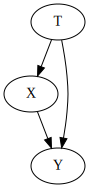

In [142]:
#DAG
g = gr.Digraph()
g.edge("T", "X")
g.edge("T", "Y")
g.edge("X", "Y")
g

In [221]:
#Generate Data
np.random.seed(570)
tau = 2
beta = 1.5
sigma = 0.1
N = 100

tau1 = tau + beta* sigma #True tau

Y, T, X = fn_generate_selection_data(tau,N,sigma,beta,conts = True)

In [222]:
data_3 = np.hstack([Y,T,X])
data_3 = pd.DataFrame(data_3)
data_3.columns = ["Y","Treatment","X"]
data_3.to_csv("data_3.csv")

In [220]:
#control for the variable in between the path from cause to effect
np.random.seed(570)
tau = 2
beta = 1.5
sigma = 0.1
N = [100,1000]

tau1 = tau + beta* sigma

estDict = run_mc_simulation(n_rep,tau,N,sigma,beta,conts=True)
summarize_mc_simulation(tau,sigma,beta,n_rep,N,estDict)

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:12<00:00, 158.97it/s]

N=100: bias=-0.1492841572377096, RMSE=0.20474954441113793, size=0.187
N=1000: bias=-0.15085236839136712, RMSE=0.15729862114151177, size=0.927


In [219]:
#Do not control for the variable in between the path from cause to effect
np.random.seed(570)
tau = 2
beta = 1.5
sigma = 0.1
N = [100,1000]

tau1 = tau + beta* sigma

estDict = run_mc_simulation(n_rep,tau,N,sigma,beta,conts=False)
summarize_mc_simulation(tau,sigma,beta,n_rep,N,estDict)

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:11<00:00, 169.33it/s]

N=100: bias=-0.0012611827008381176, RMSE=0.25089972445772857, size=0.0485
N=1000: bias=-0.00046392983084960393, RMSE=0.07913287774572977, size=0.051


Real-life example

For the effect of education (T) on personal income (Y), while personal ability (X) tends to affect both educational choice (T) and personal income (Y), i.e., personal ability (X) is a confounder of educational attainment (T) and personal income (Y).